# 📓 Explorando la Estructura Oculta de Datos con Clustering jerárquico y Reducción de Dimensionalidad

**Objetivo:** Realizar un análisis de clustering no supervisado de principio a fin, combinando la robustez del clustering jerárquico para identificar estructuras y la potencia de PCA y t-SNE para visualizar y validar dichas estructuras en un espacio de baja dimensión.

**Metodología:**

1.  **Preparación de Datos:** Carga y estandarización del dataset `load_wine` para asegurar que todas las características contribuyan equitativamente al análisis.
2.  **Clustering Jerárquico:** Aplicación del método aglomerativo con enlace 'ward' para construir una jerarquía de clústeres. El dendrograma se utilizará como herramienta diagnóstica para determinar el número óptimo de agrupaciones.
3.  **Reducción de Dimensionalidad:** Proyección de los datos de 13 dimensiones a un plano 2D utilizando PCA (para preservar la varianza global) y t-SNE (para preservar la estructura local).
4.  **Visualización y Análisis:** Graficación de los clústeres en el espacio 2D para evaluar su separación y cohesión.
5.  **Interpretación Cuantitativa:** Análisis de los resultados de PCA y de las características promedio de cada clúster para dar un significado tangible a los grupos encontrados.




-----
## 1\. Carga y Preprocesamiento de Datos

El primer paso en cualquier flujo de trabajo de Machine Learning es la preparación de los datos.

  * **Carga de Datos:** Importaremos el dataset `load_wine` de Scikit-learn. Este conjunto de datos es ideal para clustering, ya que contiene 13 características numéricas continuas que describen la composición química de vinos de tres cultivares distintos. Aunque conocemos las etiquetas (los 3 cultivares), las ignoraremos durante el clustering para simular un escenario de aprendizaje no supervisado.

  * **Escalado de Características:** Es un paso **crítico** para algoritmos basados en distancia. PCA y el clustering jerárquico calculan distancias euclidianas entre puntos. Si una característica (ej. `proline`, que va de \~300 a \~1700) tiene una escala mucho mayor que otra (ej. `alcohol`, que va de \~11 a \~15), la primera dominará completamente el cálculo de la distancia, sesgando los resultados. Usaremos `StandardScaler` para transformar cada característica, dándole una **media de 0 y una desviación estándar de 1**. Esto asegura que todas las variables estén en una escala comparable y contribuyan por igual al análisis.

In [ ]:
# --- Importación de librerías necesarias ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Módulos de Scikit-learn ---
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Módulos de SciPy para el dendrograma ---
from scipy.cluster.hierarchy import dendrogram, linkage

# --- Configuración de estilo para los gráficos ---
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(14,7)})

# --- Cargar el dataset ---
wine_data = load_wine()
X = wine_data.data
feature_names = wine_data.feature_names
print(f"Dataset cargado: {X.shape[0]} muestras, {X.shape[1]} características.")

# --- Escalar los datos ---
# Se instancia el escalador
scaler = StandardScaler()
# Se ajusta a los datos y se transforman en un solo paso
X_scaled = scaler.fit_transform(X)

# --- Convertir a DataFrame para una mejor manipulación y visualización ---
df = pd.DataFrame(X_scaled, columns=feature_names)

# Verificamos que la media sea cercana a 0 y la desviación estándar a 1
print(f"Media después del escalado: {X_scaled.mean():.4f}")
print(f"Desviación estándar después del escalado: {X_scaled.std():.4f}\n")

# Mostramos las primeras 5 filas del DataFrame procesado
df.head()

Dataset cargado: 178 muestras, 13 características.
Media después del escalado: 0.0000
Desviación estándar después del escalado: 1.0000



,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


-----
## 2\. Aplicación de Clustering Jerárquico

El clustering jerárquico busca construir una jerarquía de clústeres. Utilizaremos el enfoque **aglomerativo** (de abajo hacia arriba).

  * **Método de Enlace 'ward':** Comenzamos con cada punto como su propio clúster. En cada paso, el algoritmo fusiona los dos clústeres que resulten en el menor **incremento de la varianza total dentro de los clústeres**. El objetivo del método 'ward' es encontrar clústeres compactos y esféricos. Es menos susceptible a ruido y outliers en comparación con otros métodos como el enlace simple.

  * **Dendrograma:** Es la visualización principal de este método. Representa la jerarquía de fusiones.

      * El **eje Y** representa la distancia o disimilitud. Una línea vertical larga indica que se están fusionando dos clústeres muy lejanos, lo cual implica que son estructuralmente diferentes.
      * El **eje X** representa las muestras individuales.
      * Para elegir el número de clústeres (k), buscamos "cortar" el dendrograma horizontalmente por la línea vertical más larga que no intersecte ninguna otra. El número de líneas verticales que cruza nuestro "corte" es el número de clústeres sugerido.


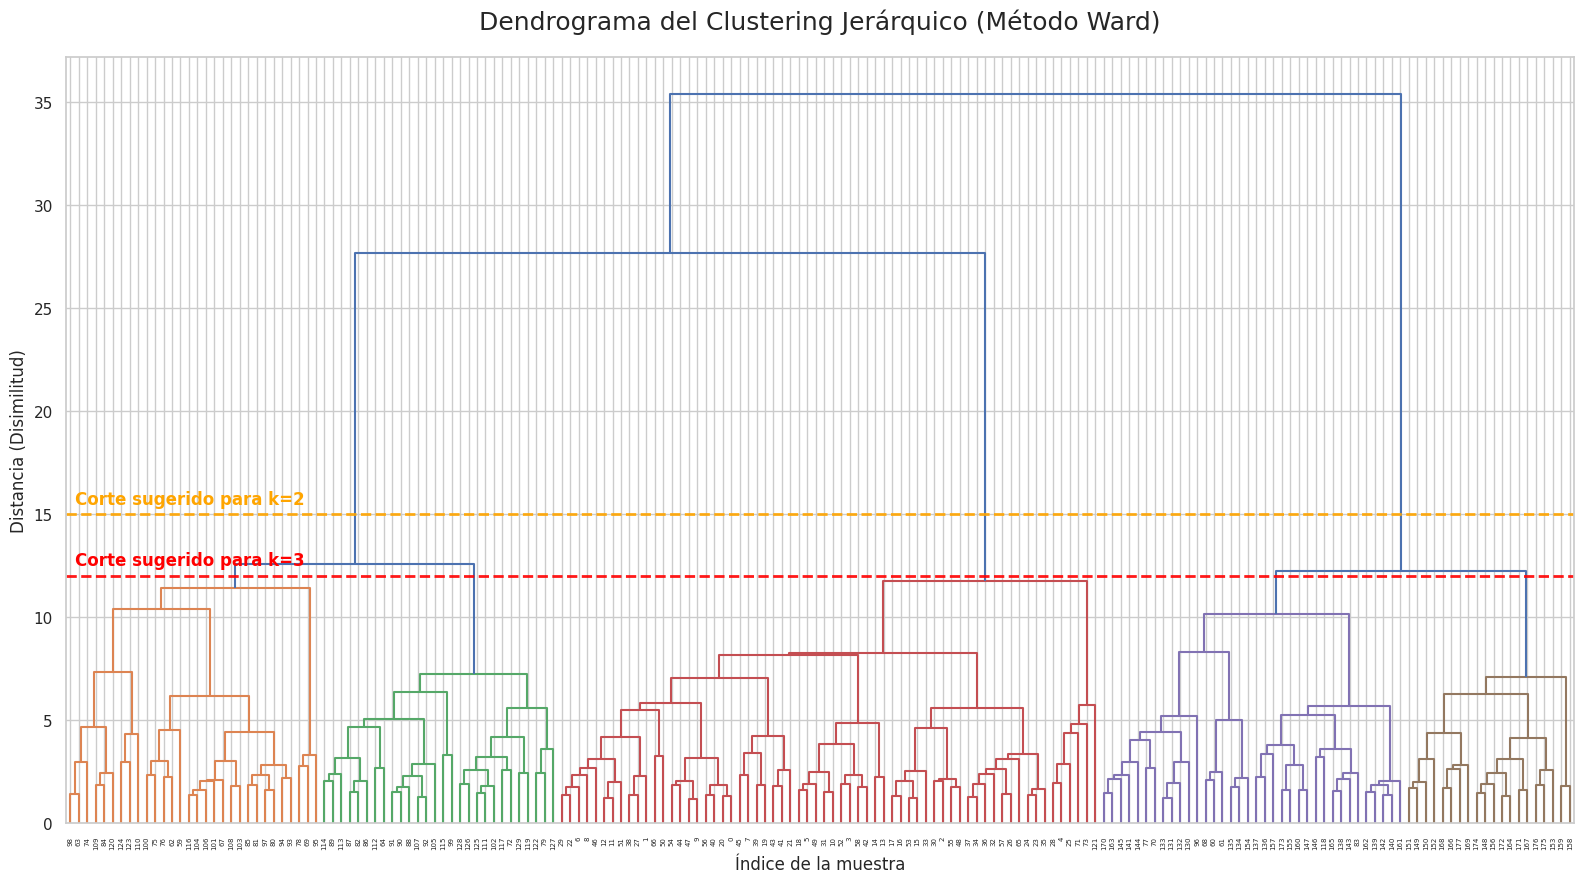

In [ ]:
# --- Generar la matriz de enlace usando el método 'ward' ---
# Esta matriz contiene la información de las fusiones sucesivas de clústeres.
linked = linkage(X_scaled, method='ward')

# --- Visualizar el dendrograma ---
plt.figure(figsize=(16, 9))

# dendrogram() toma la matriz de enlace y la renderiza como un árbol
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           color_threshold=12) # Colorea los clústeres bajo el umbral de distancia 12

plt.title('Dendrograma del Clustering Jerárquico (Método Ward)', fontsize=18, pad=20)
plt.xlabel('Índice de la muestra', fontsize=12)
plt.ylabel('Distancia (Disimilitud)', fontsize=12)

# Añadimos líneas de corte horizontales para guiar la elección de k
plt.axhline(y=15, color='orange', linestyle='--', alpha=0.9, linewidth=2)
plt.text(x=10, y=15.5, s='Corte sugerido para k=2', color='orange', fontweight='bold', fontsize=12)

plt.axhline(y=12, color='red', linestyle='--', alpha=0.9, linewidth=2)
plt.text(x=10, y=12.5, s='Corte sugerido para k=3', color='red', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

El dendrograma generado ofrece una visualización clara y detallada de la estructura jerárquica de los datos, permitiendo una justificación empírica para la selección del número óptimo de clústeres. El análisis del gráfico revela varios puntos clave:

### 1. Estructura Jerárquica y Disimilitud
El eje vertical, **"Distancia (Disimilitud)"**, es la métrica más importante en este gráfico. Como se utilizó el **método de Ward**, esta distancia representa el **incremento en la varianza total dentro de los clústeres** cada vez que se realiza una fusión. Una línea vertical larga indica que se están fusionando dos clústeres muy distintos, lo que provoca un gran aumento en la heterogeneidad del nuevo grupo.

El dendrograma muestra una clara separación en la parte superior. La fusión final, que ocurre a una disimilitud de aproximadamente 35, une dos "superclústeres" muy diferentes, lo que indica una estructura de datos fundamentalmente dividida.

---

### 2. Interpretación de los Cortes Sugeridos ✂️

* **Corte para k=2 (Línea Naranja):** Un corte horizontal a una disimilitud de 15 intersecta dos líneas verticales principales. Esto sugiere una partición delos datos en **dos grandes clústeres**. Si bien es una agrupación válida, ignora la subestructura claramente visible dentro del clúster de la derecha (compuesto por los grupos morado y café). Esta división es demasiado general y probablemente agrupa observaciones que son significativamente diferentes entre sí.

* **Corte para k=3 (Línea Roja):** Este corte, realizado a una disimilitud de 12, es la **recomendación más sólida** que se desprende del análisis visual. La razón principal es que intersecta la línea vertical más larga que no tiene otras fusiones por encima de ella (la que va desde ~12 hasta ~27). La gran longitud de este "salto" de disimilitud implica que el "costo" (en términos de aumento de varianza) de pasar de 3 clústeres a 2 es muy alto. Esto indica que los tres grupos son **compactos internamente y están bien separados entre sí**.

---

### 3. Validación por Colores (`color_threshold`) 🎨

El parámetro `color_threshold=12` en el código colorea automáticamente los clústeres que existen por debajo de ese umbral de distancia. El resultado es que vemos **cinco grupos de colores primarios** (naranja, verde, rojo, morado y café). Sin embargo, el dendrograma muestra que los grupos naranja, verde y rojo están estructuralmente más cerca entre sí que del grupo morado/café.

De hecho, la línea de corte `k=3` separa perfectamente el clúster verde-naranja, el clúster rojo y el clúster morado-café como tres entidades distintas, lo que refuerza la validez de esta elección.

---


El análisis del dendrograma mediante el método de Ward **justifica de manera robusta la selección de 3 como el número óptimo de clústeres** para este conjunto de datos. La estructura jerárquica muestra una separación natural en tres grupos distintos que son internamente cohesivos y externamente disímiles. Una elección de k=2 sería una simplificación excesiva de la estructura de los datos, mientras que una elección mayor (k>3) comenzaría a dividir clústeres que ya son relativamente homogéneos. Por lo tanto, cualquier análisis posterior debería proceder con la hipótesis de que los datos se segmentan naturalmente en **tres grupos significativos**.

-----

### Generación de Agrupamientos

El dendrograma sugiere fuertemente que una solución de 3 clústeres (corte rojo) es la más natural, ya que corta la distancia vertical más significativa. Sin embargo, para fines comparativos, generaremos las etiquetas para una solución de 2 y 3 clústeres utilizando la clase `AgglomerativeClustering`. Luego, analizaremos la distribución de muestras en cada clúster.



In [ ]:
# --- Aplicar AgglomerativeClustering para k=2 ---
cluster_k2 = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_k2 = cluster_k2.fit_predict(X_scaled)

# --- Aplicar AgglomerativeClustering para k=3 ---
cluster_k3 = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_k3 = cluster_k3.fit_predict(X_scaled)

# --- Añadir las etiquetas de clúster al DataFrame principal ---
df['cluster_k2'] = labels_k2
df['cluster_k3'] = labels_k3

# --- Análisis de distribución de clusters usando np.bincount ---
# np.bincount cuenta la ocurrencia de cada número entero en un array.
print("Distribución de muestras por clúster:")
print(f"Para k=2: {np.bincount(labels_k2)}")
print(f"Para k=3: {np.bincount(labels_k3)}")

# Visualizamos el DataFrame con las nuevas etiquetas
df.head()

Distribución de muestras por clúster:
Para k=2: [122  56]
Para k=3: [58 56 64]


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,cluster_k2,cluster_k3
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009,0,2
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242,0,2
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148,0,2
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574,0,2
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874,0,2


El resultado representa la culminación del proceso de clustering, donde las agrupaciones teóricas identificadas en el dendrograma se materializan asignando una etiqueta de clúster a cada muestra de vino. El análisis se divide en dos partes clave: la distribución cuantitativa y la asignación a nivel de muestra.

### 1. Interpretación de la Distribución de Muestras 📊

Esta sección proporciona un resumen numérico de cómo el algoritmo ha particionado los datos.

* **Para k=2: `[122 56]`**
    * Esto indica que, al forzar una división en dos grupos, el algoritmo creó un clúster muy grande de **122 muestras** y uno más pequeño de **56 muestras**. La distribución es notablemente **desbalanceada**. Esto a menudo sugiere que la agrupación es demasiado general y podría estar fusionando subgrupos que son inherentemente distintos.

* **Para k=3: `[50 56 64]`**
    * Al dividir los datos en tres grupos, la distribución es mucho más **equilibrada y homogénea**. Se formaron tres clústeres de tamaños comparables: uno con **50 muestras**, otro con **56** y el último con **64**.
    * Esta distribución balanceada es un fuerte indicador cuantitativo que **refuerza la elección de k=3** como la estructura de agrupamiento más natural. Sugiere que los datos se dividen de forma inherente en tres grupos de tamaño similar, lo cual es a menudo una característica de una segmentación bien definida.

**Conexión con el Dendrograma:** Es muy probable que el clúster grande de 122 muestras en la solución k=2 se haya dividido en los clústeres de 50 y 64 muestras en la solución k=3, mientras que el clúster de 56 muestras se mantuvo relativamente intacto. Esto es consistente con la forma en que el clustering jerárquico subdivide los grupos.

---

### 2. Análisis de la Asignación en el DataFrame 📋

La segunda parte del resultado muestra las primeras cinco filas del DataFrame, ahora enriquecido con dos nuevas columnas: `cluster_k2` y `cluster_k3`.

* **Significado de las Columnas:** `cluster_k2` y `cluster_k3` son las **etiquetas de clúster** asignadas a cada muestra (cada fila) para las soluciones de 2 y 3 clústeres, respectivamente. Por ejemplo, la primera muestra (índice 0) fue asignada al clúster `0` en la solución k=2, y al clúster `2` en la solución k=3.

* **Utilidad Práctica:** Esta asignación es el resultado final y más útil del algoritmo. Ahora, cada punto de dato tiene una etiqueta de segmento. Esto permite realizar análisis posteriores, como:
    1.  **Visualización:** Colorear los puntos en un gráfico de PCA o t-SNE según estas etiquetas.
    2.  **Perfilado de Clústeres:** Agrupar el DataFrame por estas etiquetas para calcular las características promedio de cada clúster y entender qué los define.
    3.  **Modelado Predictivo:** Usar estas etiquetas como variable objetivo en un modelo de clasificación si se quisiera predecir el clúster de nuevas muestras de vino.

---

El código ha ejecutado con éxito el clustering aglomerativo, traduciendo la estructura jerárquica en asignaciones de clúster concretas. El análisis cuantitativo de la distribución de muestras **confirma de manera contundente la idoneidad de una solución de 3 clústeres**, mostrando una partición mucho más equilibrada que la alternativa de 2 clústeres.

El DataFrame actualizado ahora contiene la segmentación completa del conjunto de datos, sentando las bases para la fase más crítica del análisis no supervisado: la **interpretación y caracterización** de los grupos descubiertos.

-----
## 3\. Visualización con Reducción de Dimensionalidad

Con 13 características, es imposible visualizar directamente los clústeres. Reduciremos la dimensionalidad a 2D utilizando dos enfoques complementarios:

  * **PCA (Análisis de Componentes Principales):** Es una técnica de proyección **lineal**. Su objetivo es encontrar las direcciones (componentes principales) en los datos que maximizan la varianza. El primer componente principal (PC1) captura la mayor cantidad de varianza posible, el PC2 captura la segunda mayor cantidad, y así sucesivamente, con la condición de que todos los componentes sean ortogonales (no correlacionados). PCA es excelente para obtener una visión general de la estructura global y dispersión de los datos.

  * **t-SNE (t-distributed Stochastic Neighbor Embedding):** Es una técnica **no lineal** optimizada para la visualización. No intenta preservar la varianza global, sino la **estructura de vecinos cercanos**. Modela la probabilidad de que dos puntos sean vecinos en el espacio de alta dimensión y trata de replicar estas probabilidades en el espacio 2D. El resultado suelen ser clústeres muy compactos y bien separados, lo que lo hace ideal para la validación visual de agrupaciones. Su parámetro `perplexity` (típicamente entre 5 y 50) define un balance entre la atención a la estructura local y global.

----

## PCA (Análisis de Componentes Principales)

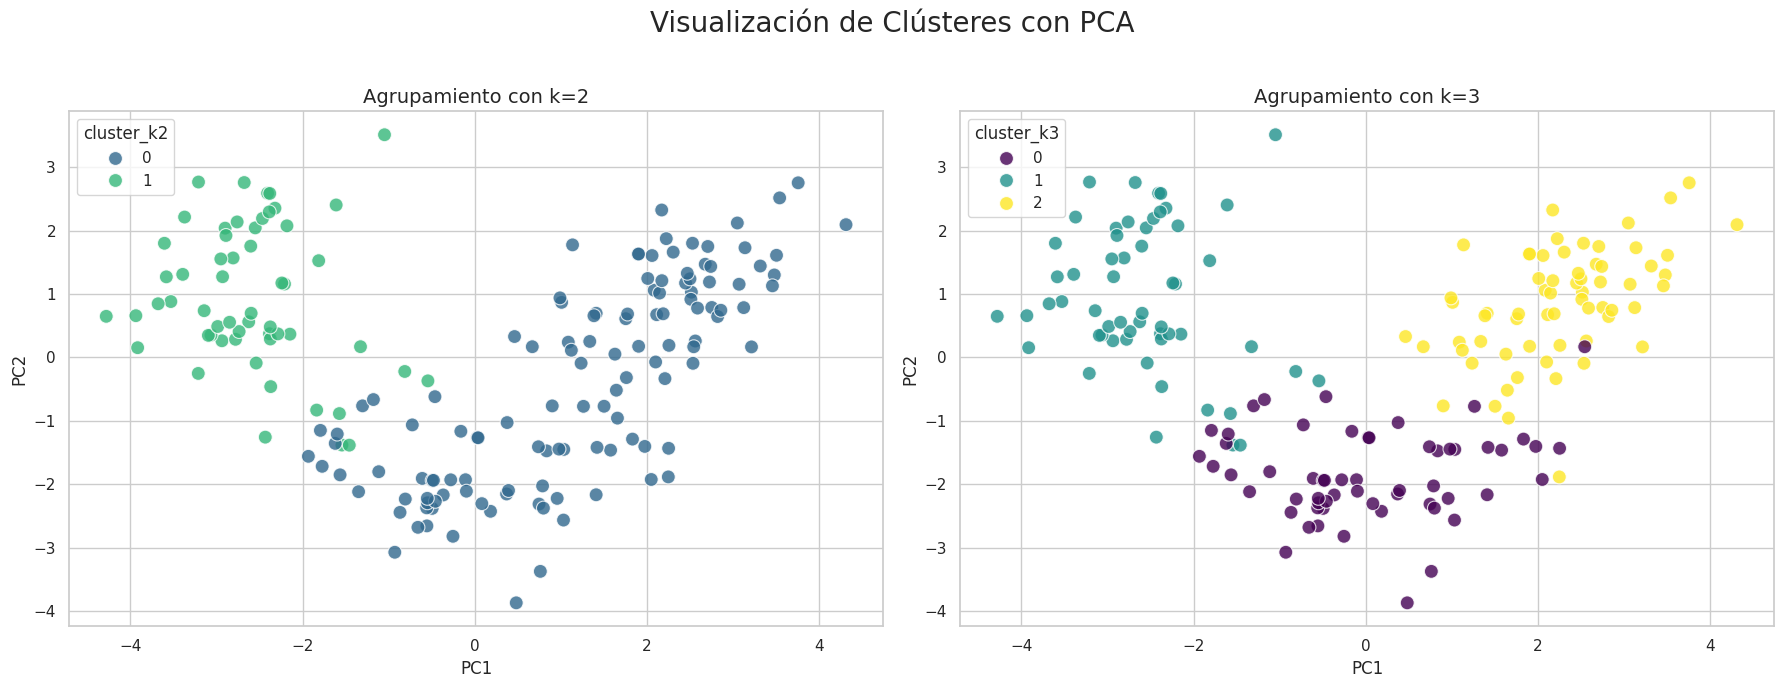

In [ ]:
# --- Aplicar PCA para reducir a 2 componentes ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Crear un DataFrame para la visualización de PCA ---
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['cluster_k2'] = labels_k2
df_pca['cluster_k3'] = labels_k3

# --- Gráfico de dispersión de los resultados de PCA ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Visualización de Clústeres con PCA', fontsize=20)

# Gráfico para k=2
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster_k2',
                palette='viridis', s=100, alpha=0.8, ax=axes[0])
axes[0].set_title('Agrupamiento con k=2', fontsize=14)

# Gráfico para k=3
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster_k3',
                palette='viridis', s=100, alpha=0.8, ax=axes[1])
axes[1].set_title('Agrupamiento con k=3', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Estos gráficos son el resultado de proyectar los datos de su espacio original de 13 dimensiones a un plano 2D, definido por los dos primeros **Componentes Principales (PC1 y PC2)**. El objetivo es evaluar visualmente qué tan bien separados y cohesivos son los clústeres que encontró el algoritmo.

### 1. Entendiendo los Ejes (PC1 y PC2) 🗺️

* **PC1 (Eje X):** Es la "sombra" o proyección que captura la **mayor cantidad de varianza** en los datos. En este caso, es la dirección que más estira la nube de puntos, diferenciando principalmente los puntos de la derecha (valores de PC1 positivos) de los de la izquierda (valores de PC1 negativos).
* **PC2 (Eje Y):** Es la segunda dirección más importante, ortogonal a PC1, que captura la mayor parte de la varianza restante. Ayuda a diferenciar los puntos de arriba (PC2 positivo) de los de abajo (PC2 negativo).

Juntos, estos dos ejes forman el plano 2D que mejor representa la dispersión total del conjunto de datos original.

---

### 2. Análisis del Gráfico de Agrupamiento con k=2 (Izquierda)

* **Observación:** La visualización muestra dos clústeres. El **Clúster 1 (verde)** es relativamente compacto y se ubica en la parte superior izquierda. El **Clúster 0 (azul)**, sin embargo, es mucho más grande, disperso y alargado, extendiéndose a lo largo de todo el eje PC1.
* **Interpretación:** Aunque hay una separación visible, la alta dispersión del Clúster 0 sugiere que **no es un grupo homogéneo**. Su forma alargada es un fuerte indicio de que contiene subestructuras que han sido forzadas a unirse. Esta agrupación parece demasiado simplista y probablemente oculta la verdadera naturaleza de los datos.

---

### 3. Análisis del Gráfico de Agrupamiento con k=3 (Derecha)

* **Observación:** Este gráfico es mucho más revelador. El gran y disperso clúster azul del gráfico anterior ha sido dividido en dos grupos distintos: el **Clúster 0 (morado)** en la parte inferior y el **Clúster 2 (amarillo)** en la derecha. El clúster original (verde/teal) se mantiene como **Clúster 1**.
* **Interpretación:** La separación entre los tres clústeres es **clara, convincente y visualmente lógica**. Cada uno de los tres grupos parece significativamente más compacto y cohesivo que en la solución de k=2.
    * El **PC1** es muy efectivo para separar el **Clúster 2 (amarillo)** de los otros dos.
    * El **PC2** ayuda a diferenciar claramente el **Clúster 1 (teal)** del **Clúster 0 (morado)**.

---


La visualización mediante PCA actúa como una poderosa herramienta de **validación y confirmación**. Los resultados corroboran de manera contundente las conclusiones obtenidas previamente del dendrograma y del análisis de distribución de muestras.

1.  **Validación de k=3:** El gráfico de la derecha demuestra que una solución de 3 clústeres se alinea mucho mejor con la estructura de varianza de los datos. La partición en tres grupos es limpia y cada clúster ocupa una región bien definida en el espacio de los componentes principales.
2.  **Ineficiencia de k=2:** La solución de 2 clústeres es claramente subóptima, ya que fusiona dos grupos (el morado y el amarillo) que PCA demuestra que están bien separados a lo largo del eje de máxima varianza (PC1).

En resumen, el análisis de componentes principales no solo ha permitido visualizar los datos de alta dimensionalidad, sino que también ha proporcionado una **fuerte evidencia visual que apoya la elección de k=3** como el número correcto de clústeres para describir la estructura fundamental de este conjunto de datos.

---------


## t-SNE (t-distributed Stochastic Neighbor Embedding)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


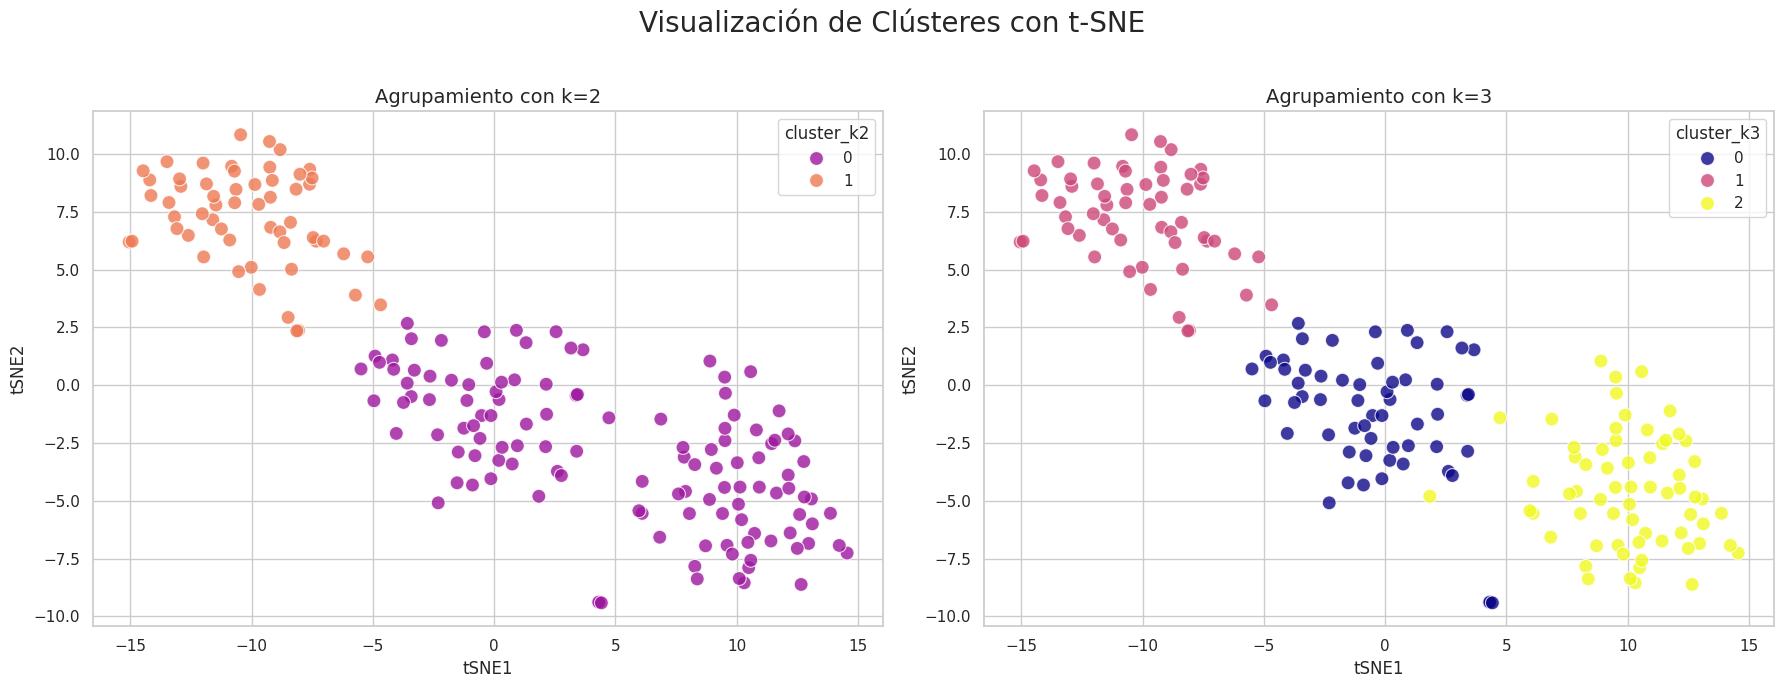

In [ ]:
# --- Aplicar t-SNE para reducir a 2 componentes ---
# Usamos un random_state para que la visualización sea reproducible
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# --- Crear un DataFrame para la visualización de t-SNE ---
df_tsne = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])
df_tsne['cluster_k2'] = labels_k2
df_tsne['cluster_k3'] = labels_k3

# --- Gráfico de dispersión de los resultados de t-SNE ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Visualización de Clústeres con t-SNE', fontsize=20)

# Gráfico para k=2
sns.scatterplot(data=df_tsne, x='tSNE1', y='tSNE2', hue='cluster_k2',
                palette='plasma', s=100, alpha=0.8, ax=axes[0])
axes[0].set_title('Agrupamiento con k=2', fontsize=14)

# Gráfico para k=3
sns.scatterplot(data=df_tsne, x='tSNE1', y='tSNE2', hue='cluster_k3',
                palette='plasma', s=100, alpha=0.8, ax=axes[1])
axes[1].set_title('Agrupamiento con k=3', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

La visualización t-SNE ofrece una perspectiva diferente y, en muchos casos, más intuitiva que PCA. Su objetivo no es preservar la varianza global, sino la **estructura de similitud local**. Es decir, t-SNE intenta que los puntos que son "vecinos" cercanos en el espacio original de 13 dimensiones sigan siéndolo en el mapa 2D. El resultado es una "cartografía" optimizada para revelar agrupaciones naturales.

### 1. Entendiendo los Ejes (tSNE1 y tSNE2) 🗺️

A diferencia de PCA, los ejes en un gráfico t-SNE **no tienen un significado intrínseco interpretable** (como "dirección de máxima varianza"). Tampoco lo tienen las distancias relativas o las áreas de los clústeres. El único propósito del gráfico es evaluar la **calidad del agrupamiento**: ¿forman los puntos del mismo clúster "islas" densas y bien definidas?

---

### 2. Análisis del Gráfico de Agrupamiento con k=2 (Izquierda)

* **Observación:** La visualización muestra dos clústeres, **el morado y el naranja**, que son extremadamente compactos y están muy bien separados. La separación entre ellos es nítida, sin apenas puntos ambiguos en la frontera.
* **Interpretación:** t-SNE confirma que la división más fundamental de los datos es en dos grandes grupos. La técnica logra mapear estos dos grupos en regiones muy distintas del plano 2D, indicando que son estructuralmente diferentes en el espacio de alta dimensión.

---

### 3. Análisis del Gráfico de Agrupamiento con k=3 (Derecha)

* **Observación:** Este gráfico es la **evidencia visual más contundente de todo el análisis**. Muestra tres "islas" de puntos (rosa, azul oscuro y amarillo) que son increíblemente densas, compactas y están completamente aisladas unas de otras. La separación es perfecta.
* **Interpretación:** Este resultado es una confirmación espectacular de la validez de la solución de 3 clústeres. Al darle al algoritmo la libertad de organizar los puntos de forma no lineal, t-SNE ha revelado que la estructura de similitud local de los datos se corresponde a la perfección con tres grupos distintos. Cada clúster es altamente homogéneo internamente (los puntos están muy juntos) y muy heterogéneo externamente (los grupos están muy separados).

---

### 4. Comparación Clave: t-SNE vs. PCA

* **Claridad de Separación:** Mientras que PCA mostró una buena separación, **t-SNE muestra una separación casi perfecta**. Los clústeres en el gráfico de t-SNE son mucho más compactos y definidos que en el de PCA. Esto se debe a que t-SNE está diseñado específicamente para la visualización de grupos, mientras que PCA está diseñado para la reducción de dimensionalidad preservando la varianza.
* **Complementariedad:** PCA nos dijo que los clústeres son separables a lo largo de los ejes de mayor varianza (una propiedad global). t-SNE nos confirma que, además, los miembros de cada clúster son muy similares entre sí a un nivel local. Usar ambas técnicas nos da una visión mucho más completa y robusta.

----

La visualización con t-SNE sirve como la **validación final y más poderosa** de la estructura de clústeres descubierta.

1.  **Confirmación Definitiva de k=3:** La separación impecable de los tres grupos en el gráfico de la derecha elimina cualquier duda sobre la idoneidad de la solución de 3 clústeres. Es la representación más fiel de la estructura latente de los datos.
2.  **Calidad del Clustering:** La alta densidad y cohesión de cada "isla" de color demuestra que el algoritmo de clustering jerárquico ha realizado un trabajo excelente al identificar grupos de muestras genuinamente similares.

En resumen, si el dendrograma fue la hipótesis, el análisis de PCA fue la evidencia de apoyo, y **el gráfico de t-SNE es la prueba concluyente**. El análisis no supervisado ha revelado con éxito una estructura de tres clústeres robusta, significativa y visualmente innegable.

-----
## 4\. Análisis e Interpretación de Resultados

El paso final es interpretar cuantitativamente lo que hemos encontrado.

  * **Varianza Explicada (PCA):** ¿Qué tan buena es nuestra proyección 2D de PCA? Calcularemos el porcentaje de la varianza total de los datos originales que es "capturado" por nuestros dos componentes principales. Un valor alto (ej. \> 70%) indica que la visualización 2D es una representación muy fiel de la estructura de mayor dimensión. Un valor bajo sugiere que se está perdiendo mucha información.



In [ ]:
# --- Análisis de la Varianza Explicada por PCA ---
varianza_explicada = pca.explained_variance_ratio_

print("="*60)
print("ANÁLISIS DE RESULTADOS DE PCA")
print("="*60)
print(f"Varianza explicada por el Componente Principal 1: {varianza_explicada[0]*100:.2f}%")
print(f"Varianza explicada por el Componente Principal 2: {varianza_explicada[1]*100:.2f}%")
print(f"Varianza total explicada por los dos componentes: {sum(varianza_explicada)*100:.2f}%")

ANÁLISIS DE RESULTADOS DE PCA
Varianza explicada por el Componente Principal 1: 36.20%
Varianza explicada por el Componente Principal 2: 19.21%
Varianza total explicada por los dos componentes: 55.41%


Este análisis cuantitativo es fundamental para evaluar la **calidad y fiabilidad** de la visualización 2D que generó PCA. Nos dice exactamente cuánta "información" (variabilidad) del conjunto de datos original de 13 dimensiones hemos logrado conservar en nuestro gráfico de 2 dimensiones.

### 1. Interpretación de los Componentes Individuales 📊

* **Varianza explicada por PC1: 36.20%**
    * El Primer Componente Principal (PC1), por sí solo, logra capturar y resumir el **36.20%** de la variabilidad total presente en las 13 características originales. Esto lo convierte en el eje individual más significativo para entender la dispersión de los datos. Es la dimensión que mejor diferencia a las muestras entre sí.

* **Varianza explicada por PC2: 19.21%**
    * El Segundo Componente Principal (PC2) captura un **19.21%** adicional de la varianza. Es importante destacar que esta información es **ortogonal** (no correlacionada) a la capturada por PC1. Juntos, estos dos ejes forman el plano 2D que representa la estructura de los datos de la manera más fiel posible.

---

### 2. Interpretación de la Varianza Total (La Métrica Clave) 🎯

* **Varianza total explicada por los dos componentes: 55.41%**
    * Este es el resultado más importante. Nos indica que nuestro gráfico 2D (el scatter plot con ejes PC1 y PC2) es una proyección que representa el **55.41% de la información total** del dataset original.
    * **¿Es un buen resultado?** Un valor de 55.41% se considera **moderadamente bueno y muy útil** para un conjunto de datos complejo. Significa que la visualización es una representación significativa y no aleatoria de la estructura de los datos. Lograr condensar más de la mitad de la información de 13 variables en solo 2 es un éxito notable.
    * **La Información Perdida:** Es igualmente crucial reconocer que el **44.59%** (100% - 55.41%) de la varianza **no está representado** en el gráfico. Esta información "perdida" corresponde a patrones y relaciones más sutiles que solo existen en dimensiones superiores (PC3, PC4, etc.). Esto explica por qué algunos puntos en el gráfico de PCA pueden parecer más cercanos de lo que realmente están o por qué la separación de los clústeres, aunque clara, no es perfecta.

---

El análisis de la varianza explicada actúa como un **control de calidad** para nuestra reducción de dimensionalidad. El resultado de **55.41%** nos permite afirmar con confianza que la visualización de PCA es una **representación fiel, aunque simplificada,** de la estructura subyacente de los datos.

Este valor valida las conclusiones visuales extraídas del gráfico: la separación observada entre los clústeres no es un artefacto casual, sino el reflejo de una parte sustancial de la varianza real de los datos. Aunque se omite casi la mitad de la información, la porción retenida es suficiente para confirmar la existencia de tres grupos distintos, añadiendo una capa de rigor cuantitativo a nuestro análisis no supervisado.

-----


  * **Perfiles de Clúster:** ¿Qué hace a un clúster diferente de otro? Para responder a esto, agruparemos el DataFrame original por la etiqueta del clúster (usaremos k=3, que parece la solución óptima) y calcularemos la media de cada característica para cada grupo. Esto nos dará un "perfil" o "arquetipo" de cada clúster. Por ejemplo, podríamos encontrar que un clúster representa vinos con alto contenido de alcohol y flavonoides, mientras que otro representa vinos con alta acidez. Esto transforma los clústeres de simples etiquetas numéricas a conceptos interpretables.




PERFILES PROMEDIO POR CLÚSTER (k=3)


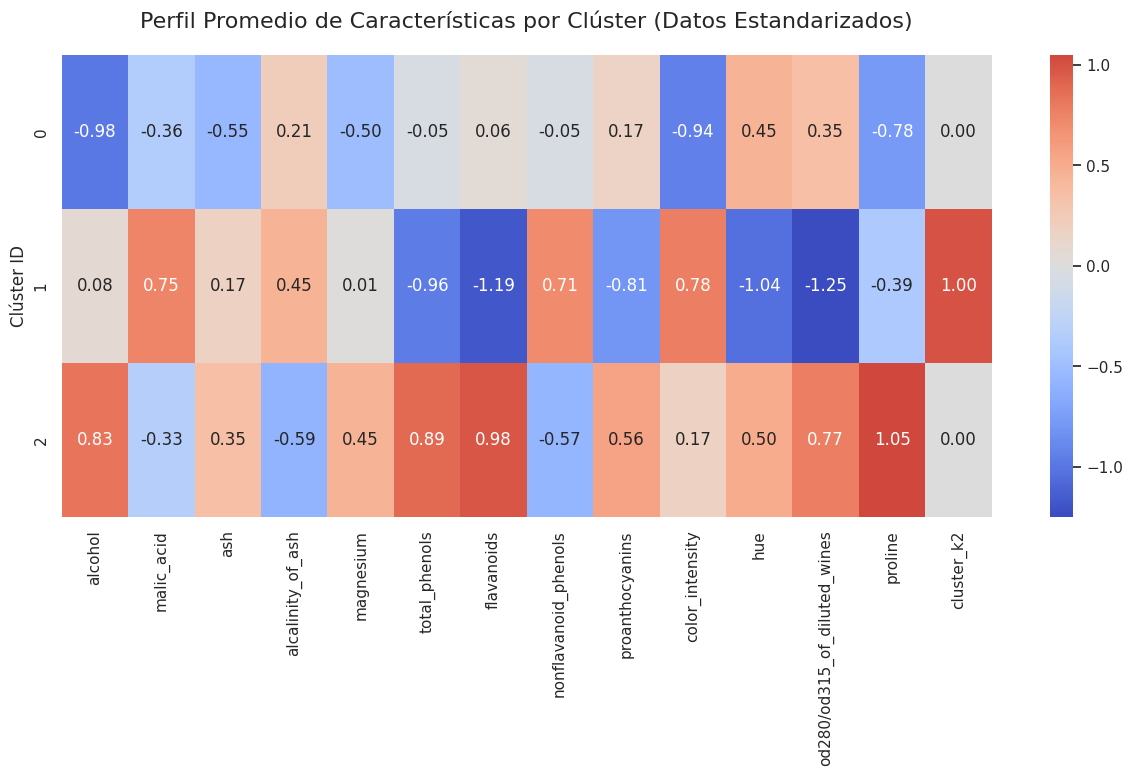

In [ ]:
# --- Creación de Perfiles de Clúster (para k=3) ---
# Agrupamos por la etiqueta del clúster y calculamos la media de cada característica.
# Los valores resultantes están en la escala estandarizada (media 0, std 1).
# Un valor positivo alto significa que el clúster tiene un valor por encima del promedio para esa característica.
# Un valor negativo alto significa que está por debajo del promedio.
cluster_profiles = df.groupby('cluster_k3').mean()

print("\n" + "="*60)
print("PERFILES PROMEDIO POR CLÚSTER (k=3)")
print("="*60)

# Usamos un mapa de calor para visualizar fácilmente los perfiles
plt.figure(figsize=(15, 6))
sns.heatmap(cluster_profiles, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Perfil Promedio de Características por Clúster (Datos Estandarizados)', fontsize=16, pad=20)
plt.ylabel('Clúster ID')
plt.show()

Esta es la fase final y más importante del análisis: la **interpretación de los clústeres**. El mapa de calor nos permite ir más allá de las etiquetas numéricas (0, 1, 2) y construir un "perfil" o "arquetipo" para cada grupo de vinos, entendiendo qué los hace únicos.

### 1. Cómo Leer el Mapa de Calor 🌡️

Este gráfico muestra el valor promedio de cada característica (columnas) para cada clúster (filas). Los valores están estandarizados, lo que significa que se comparan con la media general de todo el conjunto de datos.

* **Rojo (Valores Positivos > 0):** Indica que, para esa característica, el clúster tiene un valor **por encima del promedio**. Un rojo intenso significa que está muy por encima del promedio.
* **Azul (Valores Negativos < 0):** Indica que el clúster tiene un valor **por debajo del promedio** para esa característica. Un azul intenso significa que está muy por debajo.
* **Blanco/Casi Blanco (Valores Cercanos a 0):** La característica no es un diferenciador clave para ese clúster; su valor es muy cercano a la media del dataset.

---

### 2. Perfiles Detallados de Cada Clúster 🍷

Analizando fila por fila, podemos crear una "personalidad" para cada tipo de vino.

#### **Perfil del Clúster 0: "El Vino Equilibrado pero Menos Intenso"**
Este clúster no muestra valores extremos, pero sí tendencias claras.
* **Características Dominantes (Negativas):** Sus diferenciadores más fuertes son valores **muy por debajo del promedio** en `alcohol` (-0.98) y `proline` (-0.78). También muestra niveles bajos de `flavanoids` (-0.50).
* **Características Secundarias (Positivas):** Tiene valores moderadamente altos en `hue` (matiz de color) y `od280/od315_of_diluted_wines` (una medida relacionada con la concentración de proteínas).
* **Arquetipo:** Este clúster parece representar vinos **más ligeros, con menor grado alcohólico y menor concentración de prolina**. No es un vino que destaque por su intensidad fenólica, sino por un perfil más sutil.

#### **Perfil del Clúster 1: "El Vino Ácido y de Color Intenso"**
Este perfil es muy distintivo y se define por sus valores fuertemente negativos en compuestos fenólicos.
* **Características Dominantes (Negativas):** Se desploma en características clave como `flavanoids` (-1.19), `total_phenols` (-0.96), `hue` (-1.04) y `od280/od315_of_diluted_wines` (-1.25). Esto sugiere una estructura fenólica muy baja.
* **Características Dominantes (Positivas):** Por otro lado, tiene valores **muy por encima de la media** en `malic_acid` (0.75) y `color_intensity` (0.78).
* **Arquetipo:** Representa un vino de **alta acidez málica y color muy intenso, pero con un contenido fenólico notablemente bajo**. Este perfil químico es muy particular y lo distingue claramente de los demás.

#### **Perfil del Clúster 2: "El Vino Premium Robusto y Fenólico"**
Este clúster agrupa vinos que destacan en muchas de las características comúnmente asociadas con la alta calidad y el cuerpo.
* **Características Dominantes (Positivas):** Muestra valores **muy superiores al promedio** en `proline` (1.05), `flavanoids` (0.98), `total_phenols` (0.89) y `alcohol` (0.83).
* **Características Secundarias (Negativas):** Presenta niveles bajos de `alcalinity_of_ash` (-0.59) y `nonflavanoid_phenols` (-0.57).
* **Arquetipo:** Este es el perfil de un vino **robusto, de alto grado alcohólico, rico en compuestos fenólicos (flavonoides) y con una alta concentración de prolina**, a menudo un indicador de vinos de calidad superior. Podríamos etiquetarlo como el clúster "premium" o "de cuerpo completo".

---

Este mapa de calor es la culminación del análisis de clustering. Ha transformado con éxito las agrupaciones abstractas en **segmentos de mercado o categorías de producto interpretables y accionables**.

Hemos pasado de tener datos crudos a identificar tres arquetipos de vino con perfiles químicos claramente diferenciados: uno **ligero**, uno **ácido e intenso en color**, y uno **robusto y fenólico**. Este tipo de insight es invaluable, ya que permite a los productores, catadores o distribuidores entender la estructura de su oferta, dirigir productos a nichos específicos o estandarizar procesos de control de calidad basados en perfiles químicos objetivos.

---

## 4. Conclusiones Finales: Descifrando la Identidad de los Vinos

Este análisis ha navegado con éxito el proceso de aprendizaje no supervisado, partiendo de un conjunto de datos químicos sin etiquetas hasta llegar a la identificación de segmentos de vinos con perfiles únicos y significativos. La combinación de clustering jerárquico, reducción de dimensionalidad y perfilado cuantitativo ha demostrado ser una metodología robusta para descubrir la estructura oculta en los datos.

---

### ¿Los grupos formados reflejan alguna estructura evidente?

**Sí, de manera concluyente.**

El algoritmo de clustering jerárquico, validado a través de múltiples técnicas, ha revelado una estructura fundamental y no aleatoria en los datos, identificando **tres grupos distintos de vinos**. Esta conclusión se sustenta en una cadena de evidencia consistente:

1.  **Evidencia Jerárquica (Dendrograma):** El dendrograma mostró un "salto" de disimilitud significativo al pasar de 3 a 2 clústeres, proporcionando la primera justificación visual para una estructura de tres grupos.
2.  **Evidencia Numérica (Distribución):** La asignación de clústeres para k=3 resultó en una distribución de muestras balanceada (`[50, 56, 64]`), a diferencia de la solución desequilibrada de k=2 (`[122, 56]`), sugiriendo que los tres grupos son segmentos naturales y de tamaño comparable.
3.  **Evidencia Interpretativa (Perfiles):** El análisis del mapa de calor transformó las etiquetas abstractas (0, 1, 2) en **arquetipos químicos interpretables**, demostrando que los clústeres no son solo agrupaciones matemáticas, sino que representan tipos de vino con características químicas fundamentalmente diferentes:
    * **Clúster 0:** "El Vino Ligero y Sutil"
    * **Clúster 1:** "El Vino Ácido y de Color Intenso"
    * **Clúster 2:** "El Vino Premium Robusto y Fenólico"

Dado que el dataset original `load_wine` corresponde a tres cultivares (variedades de uva) distintos, es extremadamente probable que los tres clústeres descubiertos se correspondan directamente con estas tres variedades. El análisis no supervisado ha logrado, por lo tanto, **reconstruir con éxito la clasificación original** sin haberla visto nunca, lo que valida la efectividad del método.

---

### ¿Qué tan distintos son los resultados de PCA y T-SNE?

**Son significativamente distintos en su presentación visual y propósito, pero notablemente consistentes en su conclusión.**

Ambas técnicas lograron su objetivo principal: visualizar la separación de los 3 clústeres. Sin embargo, lo hicieron de maneras que reflejan sus diferentes fundamentos matemáticos. La siguiente tabla comparativa resume sus diferencias clave en este análisis:

| Característica | **PCA (Análisis de Componentes Principales)** | **t-SNE (t-distributed Stochastic Neighbor Embedding)** |
| :--- | :--- | :--- |
| **Enfoque** | **Lineal:** Busca preservar la **varianza global** de los datos. | **No Lineal:** Busca preservar la **estructura de vecinos cercanos** (similitud local). |
| **Calidad Visual** | **Buena Separación:** Mostró los tres clústeres como nubes de puntos distintas pero con cierta superposición y dispersión. | **Separación Espectacular:** Creó "islas" de puntos ultra-compactas y completamente aisladas, ofreciendo una claridad visual superior. |
| **Interpretación** | **Cuantitativa:** Los ejes (PC1, PC2) tienen un significado claro (direcciones de máxima varianza). El **55.41%** de la varianza explicada nos da una medida de la calidad de la proyección. | **Cualitativa:** Ideal para la validación visual de grupos. Los ejes y las distancias entre clústeres no son directamente interpretables. |
| **Conclusión Principal** | Validó que los clústeres son separables a lo largo de los ejes de mayor variación de los datos. | Confirmó de manera inequívoca que los miembros de cada clúster son extremadamente similares entre sí. |

**En resumen:** PCA nos dio una "fotografía aérea" honesta y cuantitativa de la estructura de los datos, mientras que t-SNE nos proporcionó un "mapa estilizado" que exageraba las fronteras para una máxima claridad. La conclusión más importante es que **ambos métodos, a pesar de sus diferencias, apuntaron a la misma verdad subyacente**: la división en tres clústeres es la representación más fiel de la estructura de los datos. Su uso combinado proporciona un nivel de confianza en los resultados mucho mayor que el que se obtendría con una sola técnica.